<a href="https://colab.research.google.com/github/Fatimah007/T5/blob/main/Copy_of_Task2_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification Exam

Welcome to the Text Classification Practical Exam. In this exam, you will be tasked with building, training, and evaluating an NLP model to classify text data. You are provided with a labeled dataset containing both the text and its corresponding class labels.

Your objective is to develop a model that accurately predicts the class of the given text. Make sure to follow best practices in data preprocessing, model selection, and evaluation to achieve optimal results.

Good luck!
___

# Install and Import Needed Libraries

In [1]:
!pip install tensorflow-text

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 13.9 MB/s eta 0:00:00


In [3]:
import collections
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers import TextVectorization

# Download the Dataset

In [2]:
!kaggle datasets download -d khaledzsa/spam-messages
!unzip spam-messages.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/spam-messages
License(s): unknown
  0% 0.00/213k [00:00<?, ?B/s]
100% 213k/213k [00:00<00:00, 82.6MB/s]
Archive:  spam-messages.zip
  inflating: spam.csv                


In [4]:
!kaggle datasets download -d abedkhooli/arabic-100k-reviews

Dataset URL: https://www.kaggle.com/datasets/abedkhooli/arabic-100k-reviews
License(s): copyright-authors
 41% 7.00M/17.0M [00:00<00:00, 72.6MB/s]
100% 17.0M/17.0M [00:00<00:00, 127MB/s] 


In [5]:
!unzip arabic-100k-reviews.zip

Archive:  arabic-100k-reviews.zip
  inflating: ar_reviews_100k.tsv     


# Data Exploration

Before diving into preprocessing and model building, it’s important to first explore the dataset to understand its structure, distribution, and key characteristics. This step will help you gain insights into the data and guide your decisions in subsequent steps. Here’s what to consider:

1. **Inspect the Data**:
   Start by looking at the first few rows of the dataset to get a sense of its structure. Check the columns, data types, and a few sample entries. This helps to ensure that the data is loaded correctly and gives you an initial overview of the content.

2. **Check for Missing Values**:
   Identify if there are any missing values in the dataset.

3. **Distribution of Labels**:
   Examine the distribution of the target labels (classes).

4. **Text Data Characteristics (Bonus)**:
   Analyze the length of the text data. It is useful to calculate the number of words or characters in each text sample to understand how long the texts are. This will help you set a suitable `max_length` for tokenization and padding later. You can plot a histogram of text lengths to visualize the distribution.

5. **Common Words and Vocabulary (Bonus)**:
   Explore the most frequent words in the text data.

In [6]:
df=pd.read_csv("/content/arabic-100k-reviews.zip", sep="\t")

In [7]:
df.head()

,label,text
0,Positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1,Positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,Positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3,Positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,Positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...


In [8]:
df.sample(10)

,label,text
2326,Positive,استثنائي. موظف استقبال في دورية المساء أداءه ج...
99063,Negative,جيد . . النظافةالخدمات المطعم
91204,Negative,مخيب للأمل. الموقع بوفيه الافطار. بطء في تسجيل...
20211,Positive,رائع . الراحه.
65020,Mixed,فيها فكرة مختلفه بس مابهرتنيش
13786,Positive,ممتاز. الموقع الجغرافي لجميع الخدمات.
23543,Positive,ديوان رائع يجمع الحس الوطني الثوري والحس العاط...
19294,Positive,ماذا فعلت يا كتكوت؟ إلى أين تجري؟ وحتى متى؟. ل...
15771,Positive,خمس درجات للكتاب وليس للمترجم
62705,Mixed,شعرت بالفخر تجاه هذه الرواية من قبل أن أقرأها ...


In [9]:
df['label'].value_counts()

,count
label,
Positive,33333
Mixed,33333
Negative,33333


In [10]:
df.shape

(99999, 2)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   99999 non-null  object
 1   text    99999 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [12]:
df.isnull().sum()

,0
label,0
text,0


In [13]:
df.describe()

,label,text
count,99999,99999
unique,3,99999
top,Positive,لن ارجع إليه مرة اخرى . قربه من البحر. المكان ...
freq,33333,1


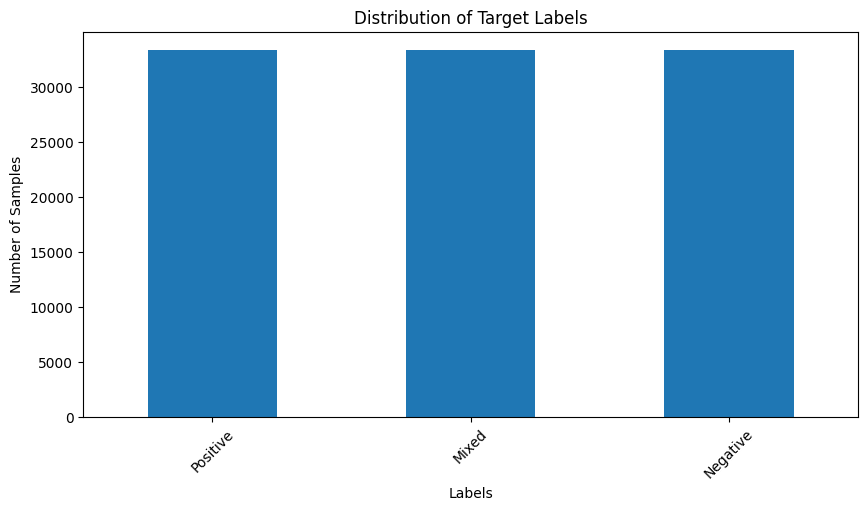

In [14]:
label_counts = df['label'].value_counts()
plt.figure(figsize=(10, 5))
label_counts.plot(kind='bar')
plt.title('Distribution of Target Labels')
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

In [15]:
# Calculate the number of words and characters
df['n_word']=df['text'].apply(lambda x:len(x.split()))
df['n_char']=df['text'].apply(len)

In [16]:
# Display the first few rows with text lengths
print(df[['text','n_word','n_char']].head())

                                                text  n_word  n_char
0  ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...       9      57
1  أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...      53     273
2  هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...      48     255
3  خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...     107     572
4  ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...      15      74


In [17]:
max_lenght=int(df['n_word'].quantile(0.95))
print(max_lenght)

197


In [18]:
# Convert text to lowercase, split into words, and count occurrences
most_common_words = (df['text']
                     .str.lower()  # Convert to lowercase
                     .str.split()  # Split into words
                     .explode()    # Create a separate row for each word
                     .value_counts()  # Count occurrences
                     .head(10)     # Get the top 10 most common words
                    )

print(most_common_words)

text
من     125536
في     116861
و       94742
.       77069
على     47328
لا      46154
..      44641
أن      37302
عن      35819
ما      34936
Name: count, dtype: int64


In [19]:
mcw=(df['text'].str.lower().str.split().explode().value_counts())

In [20]:
mcw.head(10)

,count
text,
من,125536
في,116861
و,94742
.,77069
على,47328
لا,46154
..,44641
أن,37302
عن,35819


In [21]:
max_lenght
min_length=3
df= df[(df['n_word']>=min_length)&(df['n_word']<=max_lenght)]

In [22]:
df= df[df['label'] != 'Mixed']

In [23]:
df

,label,text,n_word,n_char
0,Positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...,9,57
1,Positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...,53,273
2,Positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...,48,255
3,Positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...,107,572
4,Positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...,15,74
...,...,...,...,...
99994,Negative,معرفش ليه كنت عاوزة أكملها وهي مش عاجباني من ا...,28,172
99995,Negative,لا يستحق ان يكون في بوكنق لانه سيئ . لا شي. لا...,20,90
99996,Negative,كتاب ضعيف جدا ولم استمتع به. فى كل قصه سرد لحا...,16,72
99997,Negative,مملة جدا. محمد حسن علوان فنان بالكلمات، والوصف...,30,157


In [24]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
ar_stopword = set(stopwords.words('arabic'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [25]:
def remove_stopwords(text):
  return ' '.join([word for word in text.split() if word not in ar_stopword])

df['cleaned_text']=df['text'].apply(remove_stopwords)
print(df[['text', 'cleaned_text']].head(10))


                                                text  \
0  ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...   
1  أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...   
2  هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...   
3  خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...   
4  ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...   
5  أسلوب الكاتب رائع جدا و عميق جدا، قرأته عدة مر...   
6  استثنائي. الهدوء في الجناح مع مسبح. عدم وجود ع...   
7  الكتاب هو السيرة الذاتية للحداثة في المملكة بل...   
8       من أجمل ما قرأت.. رواية تستحق القراءة فعلا..   
9  بشكل عام جيده .. . التجاوب جيد جدا من قبل موظف...   

                                        cleaned_text  
0  ممتاز نوعا . النظافة والموقع والتجهيز والشاطيء...  
1  أسباب نجاح الإمارات شخص الدولة يعشق ترابها. نح...  
2  هادفة .. وقوية. تنقلك صخب شوارع القاهرة الى هد...  
3  خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...  
4  ياسات جلوريا جزء يتجزأ دبي . فندق متكامل الخدم...  
5  أسلوب الكاتب رائع جدا عميق جدا، قرأته عدة مرات... 

In [26]:
! pip install pyarabic

import pyarabic.araby as araby
import pyarabic.number as number

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 3.9 MB/s eta 0:00:00


In [27]:
from nltk.stem.isri import ISRIStemmer
st = ISRIStemmer()  # initialize the stemmer

# Data Cleaning and Preprocessing

In this section, we will focus on cleaning and filtering the dataset, preparing it for the text classification task. We will implement the following steps:

1. **Remove missing values**:  
   First, we eliminate any rows with missing values to ensure the dataset is complete and consistent.

2. **Filter by text length (Bonus)**:  
   To maintain a uniform dataset, we will filter the text samples by a specified word count range. This ensures that the texts are neither too short to lack context nor too long to introduce unnecessary complexity.

3. **English stopwords loading**:  
   We load a list of English stopwords to filter out commonly used but contextually insignificant words. This is an important step for improving the performance of the model, as stopwords do not contribute valuable information.

4. **Text cleaning**:  
   We apply a series of text cleaning steps to standardize and simplify the text data. This involves:
   
   - **Removing links (URLs)**:  
     Any URLs present in the text are removed as they are not meaningful for classification purposes.
   
   - **Removing special characters and punctuation**:  
     This step removes any non-alphabetical characters, ensuring the text only contains meaningful words.
   
   - **Lowercasing**:  
     All text is converted to lowercase for uniformity and to avoid case sensitivity issues.
   
   - **Removing English stopwords**:  
     Words that are part of the stopwords list are removed, as they do not add value to the classification task.
   
   - **Stemming or Lemmatization**:  
     Either stemming or lemmatization is applied to reduce words to their root or base form, ensuring consistency in word forms.

5. **Final cleanup**:
   Apply the cleanup function to the feature column.

By following these steps, the text will be cleaned, filtered, and ready for tokenization!

In [28]:
import re # imports regular expression operations

from nltk.stem.isri import ISRIStemmer
st = ISRIStemmer()  # initialize the stemmer

!pip install pyarabic # Installs the pyarabic package
import pyarabic.araby as araby # imports the araby module from the pyarabic package

# have a typo in the function name should be clean_text not cleane_text
def clean_text(text):
    cleaned_text = re.sub(r'http\s+|www\s+|https\s+', '', text, flags=re.MULTILINE)
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)
    cleaned_text = araby.strip_tashkeel(cleaned_text)  # Removes Tashkeel
    cleaned_text = araby.strip_tatweel(cleaned_text)   # Removes elongated letters
    cleaned_text = araby.strip_lastharaka(cleaned_text)  # Removes last haraka
    words = cleaned_text.split()
    cleaned_text = ' '.join([word for word in cleaned_text.split() if word not in ar_stopword])


    stemmed_words = []
    for word in words:
        stemmed_words.append(st.stem(word))
    # This line was causing the error. You should join the stemmed_words list and assign it to cleaned_text
    cleaned_text = ' '.join(stemmed_words)
    cleaned_text = araby.normalize_hamza(cleaned_text)

    return cleaned_text

cleaned_text = clean_text(df['text'][1])

In [30]:
cleaned_text = clean_text(df['text'][1])

In [31]:
print(f'Before: {df["text"][1]}')
print(f'After: {cleaned_text}')

Before: أحد أسباب نجاح الإمارات أن كل شخص في هذه الدولة يعشق ترابها. نحن نحب الإمارات. ومضات من فكر. نصائح لدولة تطمح بالصفوف الأولى و قائد لا يقبل إلا براحة شعبه وتوفر كل سب العيش الكريم. حكم و مواقف ونصائح لكل فرد فينا ليس بمجرد كتاب سياسي كما كنت اعتقد. يستحق القراءة مرات كثيرة
After: احد سبب نجح امر ان كل شخص في هذه دول عشق ترب نحن نحب امر ومض من فكر نصح لدل طمح صفف ولى و قءد لا قبل الا برح شعب وفر كل سب عيش كرم حكم و وقف نصح لكل فرد فين ليس جرد كتب سيس كما كنت عقد سحق قرء رات كثر


In [33]:
df['clean_text'] = df['text'].apply(clean_text)

In [34]:
df.head()

,label,text,n_word,n_char,cleaned_text,clean_text
0,Positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...,9,57,ممتاز نوعا . النظافة والموقع والتجهيز والشاطيء...,متز نوع ما نظف وقع جهز شاطيء طعم
1,Positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...,53,273,أسباب نجاح الإمارات شخص الدولة يعشق ترابها. نح...,احد سبب نجح امر ان كل شخص في هذه دول عشق ترب ن...
2,Positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...,48,255,هادفة .. وقوية. تنقلك صخب شوارع القاهرة الى هد...,هدف وقي نقل من صخب شرع قهر الى هدء جبل شيش عرف...
3,Positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...,107,572,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...,خلص بدء الل مست بهر زي فيل زرق ميقراش احس حمد ...
4,Positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...,15,74,ياسات جلوريا جزء يتجزأ دبي . فندق متكامل الخدم...,ياس جلر جزء لا جزء من دبي ندق كامل خدم ريح نفس...


In [35]:
print((df['clean_text'] == '').sum())  # Count empty strings

2


In [36]:
df = df.dropna(subset=['clean_text'])

# Tokenization, Padding, and Data Splitting

In this step, we will prepare the text data for input into a model by converting the text into numerical sequences, padding them to a uniform length, and splitting the dataset into training and testing sets. Here's an overview of the steps involved:

1. **Tokenization**:
   We use a tokenizer to convert the cleaned text into numerical sequences. You can use `Tokenizer` tokenizer from `tensorflow.keras.preprocessing.text` package or any other tokenizer you like.

2. **Text to sequences**:
   After fitting the tokenizer on the cleaned text, we transform each text into a sequence of numbers, where each number corresponds to a token (word) in the text.

3. **Padding the sequences**:
   Since different texts may vary in length, we pad the sequences to ensure they all have the same length.

4. **Label encoding**:
   The labels (target values) also need to be converted into numerical form if they are not encoded.

5. **Train-test split**:
   The dataset is divided into training and testing sets. We allocate 80% of the data for training the model and reserve 20% for testing its performance.
   
   - The **training data** consists of the padded sequences used to train the model.
   - The **training labels** are the encoded labels corresponding to the training data.
   - The **testing data** is used to assess the model’s performance after training.
   - The **testing labels** are the encoded labels corresponding to the testing data.

6. **Data shape confirmation**:
   After splitting the data, we print the shape (dimensions) of both the training and testing sets to confirm that the data is properly divided and formatted.

By the end of this step, the text data will be transformed into padded numerical sequences, the labels will be encoded, and the data will be split into training and testing sets for model development and evaluation.

In [37]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Bidirectional, SimpleRNN, LSTM

In [38]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])

#Text to sequences
sequences = tokenizer.texts_to_sequences(df['clean_text'])

In [39]:
#Padding the sequences
padded_sequences = pad_sequences(sequences, maxlen=max_lenght, padding='post')

In [40]:
#Label encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['label'])

In [41]:
#Train-test split

from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

#Data shape confirmation
# Confirm shapes
print(f'Training data shape: {train_data.shape}, Training labels shape: {train_labels.shape}')
print(f'Testing data shape: {test_data.shape}, Testing labels shape: {test_labels.shape}')

Training data shape: (50231, 197), Training labels shape: (50231,)
Testing data shape: (12558, 197), Testing labels shape: (12558,)


# Building the Classifier

In this step, you will design and build a NLP Classifier model to classify text data. Below is a breakdown of the key components you'll implement, but it's up to you to decide how to configure them based on your understanding and experimentation:

1. **Model Type**:
   You will use a Sequential model, which allows you to stack layers in a linear sequence.

2. **Input Layer**:
   Define the shape of the input data. Consider the dimensions of your padded sequences and set the input shape accordingly.

3. **Embedding Layer**:
   The embedding layer will convert input tokens (integers) into dense vector representations. You will need to determine the size of the input dimension (based on your vocabulary) and the output dimension (embedding size).

4. **Bidirectional Simple RNN/LSTM Layers**:
   You can add one or more recurrent layers. Consider using Bidirectional layers to capture contextual information from both directions (forward and backward). You can chose SimpleRNN/GRU/LSTM to perform this step.

5. **Dense Layers**:
   Add one or more fully connected (Dense) layers to process the output from the RNN/GRU/LSTM layers.

6. **Output Layer**:
   The output layer should match the type of classification task you're working on. Consider using appropriate activation function with appropriate number of units.

7. **Model Summary**:
   After defining your model architecture, print a summary to review the number of layers, types of layers, and total parameters.

8. **Model Compilation**:
   Finally, compile the model by selecting an optimizer, a loss function, and metrics.

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Bidirectional, SimpleRNN, LSTM

In [43]:
model = Sequential([
    # Input layer, specifying the shape of the input data (e.g., sequence length)
    Input(shape=(max_lenght,)),

    # Embedding layer to convert integer-encoded words into dense vectors of fixed size
    # input_dim: size of the vocabulary (one more than the word index size to account for padding)
    # output_dim: size of the embedding vectors
    # input_length: the length of input sequences
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_lenght),

    # Bidirectional RNN layer using SimpleRNN
    # 64 units in the RNN cell, return_sequences=True ensures that output is 3D (one output per time step)
    Bidirectional(SimpleRNN(64, return_sequences=True)),

    # Another Bidirectional SimpleRNN, this time returning only the final hidden state (2D output)
    Bidirectional(SimpleRNN(32)),

    # Dense layer (Fully connected layers)
    Dense(64, activation='relu'),

    # Output Dense layer with 1 unit (for binary classification) and sigmoid activation
    # Sigmoid activation squashes the output between 0 and 1, which is useful for binary classification
    Dense(1, activation='sigmoid')
])

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 197, 128)            │       5,693,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 197, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,733,057 (21.87 MB)

 Trainable params: 5,733,057 (21.87 MB)

 Non-trainable params: 0 (0.00 B)

# Defining Batch Size, Creating Datasets, and Training the Model

In this step, you will define the batch size, create TensorFlow Datasets for both training and testing, and train the model. The key elements to consider are outlined below, and it is up to you to choose the specific configurations based on your preferences and experimentation:

1. **Batch Size**:
   Select a batch size for training and testing. The batch size determines how many samples will be processed together in one forward and backward pass during training.

2. **Creating Datasets**:
   Use TensorFlow’s `Dataset.from_tensor_slices()` to create datasets from the training and testing data.

3. **Batching the Datasets**:
   Batch the datasets by grouping the data into batches of the specified size.

4. **Training the Model**:
   Train the model by fitting it on the training dataset for a specified number of epochs. You will also need to provide the validation data to monitor the model’s performance on unseen data during training.

5. **Tracking Training History**:
   During training, the model’s performance metrics (such as loss and accuracy) will be tracked over the epochs, and the results will be stored in the `history` object.

In [44]:
import tensorflow

batch_size = 32

# Create a TensorFlow Dataset from the training data and labels
# Dataset.from_tensor_slices creates a dataset with pairs of (input, label) tensors
train_dataset = tensorflow.data.Dataset.from_tensor_slices((train_data, train_labels))

# Create a TensorFlow Dataset from the testing data and labels
test_dataset = tensorflow.data.Dataset.from_tensor_slices((test_data, test_labels))

# Batch the datasets
# This will divide the dataset into batches of size 32 for efficient training
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Train the model using the training dataset
history = model.fit(train_dataset, epochs=5, validation_data=test_dataset)

Epoch 1/5
1570/1570 ━━━━━━━━━━━━━━━━━━━━ 155s 94ms/step - accuracy: 0.7567 - loss: 0.4655 - val_accuracy: 0.8434 - val_loss: 0.3454
Epoch 2/5
1570/1570 ━━━━━━━━━━━━━━━━━━━━ 194s 91ms/step - accuracy: 0.8501 - loss: 0.3358 - val_accuracy: 0.8219 - val_loss: 0.3801
Epoch 3/5
1570/1570 ━━━━━━━━━━━━━━━━━━━━ 180s 114ms/step - accuracy: 0.8481 - loss: 0.3415 - val_accuracy: 0.7907 - val_loss: 0.4607
Epoch 4/5
1570/1570 ━━━━━━━━━━━━━━━━━━━━ 165s 105ms/step - accuracy: 0.8526 - loss: 0.3341 - val_accuracy: 0.8250 - val_loss: 0.4331
Epoch 5/5
1570/1570 ━━━━━━━━━━━━━━━━━━━━ 180s 91ms/step - accuracy: 0.8742 - loss: 0.3005 - val_accuracy: 0.8069 - val_loss: 0.4329


# Model Evaluation

Once the model is trained, the next step is to evaluate its performance on the testing dataset.

1. **Evaluate the Model**:
   You will use the `evaluate()` method to assess the model’s performance on the test dataset.

2. **Testing Dataset**:
   Ensure that the testing dataset is properly prepared and batched, just like the training dataset.

4. **Loss Curve**:
   A loss curve plots the loss values for both the training and validation datasets over the epochs.

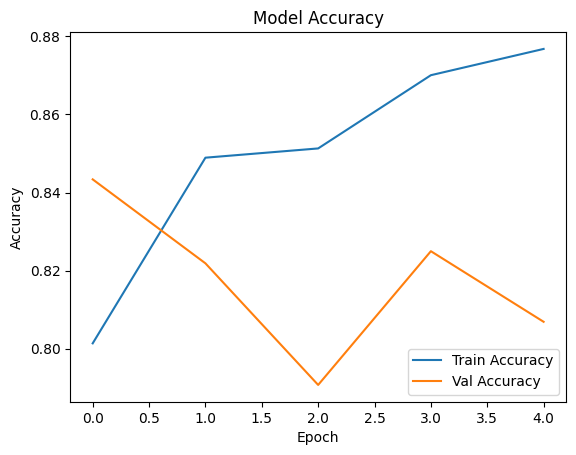

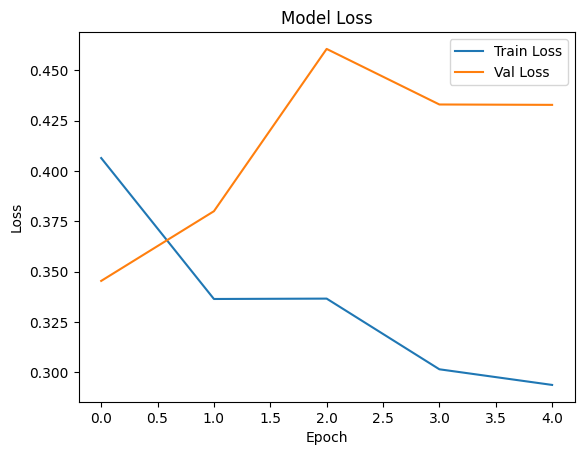

In [52]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Model Inference

In this step, you will use the trained model to make predictions on new, unseen data (inference). Here’s an outline of the key points:

1. **Create Test Sample**:
   Create a string to test your modelm the goal here is to give the model Before making predictions, ensure that the new data is preprocessed in the same way as the training data. This includes tokenization, padding, and any other transformations you applied during the data preprocessing step. The data can be single text to see the result of the prediction.

2. **Model Prediction**:
   Use the `predict()` method to feed new samples into the trained model and obtain predictions. The model will output probabilities or predicted class labels based on the type of classification task (binary or multi-class).

3. **Interpreting Predictions**:
   The model will return probabilities for each class.

In [51]:
# Define a sample text for prediction

sample_text = ['لا يستحق ان يكون في بوكنق لانه سيئ . لا شي. لا...	']
# Clean the sample text (assuming there's a function clean_text() for text preprocessing)
# This step would typically involve removing unwanted characters, stopwords, etc.
sample_sequence = tokenizer.texts_to_sequences([clean_text(sample_text[0])])

# Pad the sequence to match the maximum length used during training
# Padding ensures that the input to the model has the same shape as the training data
padded_sample_sequence = pad_sequences(sample_sequence, maxlen=max_lenght, padding='post')

# Predict the label for the padded sample sequence using the trained model
predicted_label = model.predict(padded_sample_sequence)

# Print the predicted label by converting the integer-encoded prediction back to the original label
# The label_encoder.inverse_transform() method translates the encoded label back to its original form
print("Predicted label:", label_encoder.inverse_transform([predicted_label.argmax()]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted label: ['Negative']


In [60]:

# Sample text to predict
sample_text = (
 '''الكتاب هو السيرة الذاتية للحداثة في المملكة بلسان أبرز معاصريها، هو كذلك تحليل اجتماعي لفكر المجتمع ...
'''
)
# Define vocab_size
vocab_size = 10000

# Tokenize and pad the sample text
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts([sample_text])  # Fitting on the sample text to tokenize
sample_seq = tokenizer.texts_to_sequences([sample_text])
sample_padded = pad_sequences(sample_seq, maxlen=max_lenght, padding='post')

# Make prediction
predictions = model.predict(sample_padded)
print(*predictions[0])

# Print the label based on the prediction
if predictions[0] > 0:
    print('The review is positive')
else:
    print('The review is negative')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
0.18695989
The review is positive


In [ ]:
model.save('model.h5')

# Notebook Question:
- How did you handle text preprocessing? Why did you choose this approach?

- Why did you choose this model design?

- Why did you pick this number of layers or units for the model?

- Why did you select these evaluation methods?

- Does your model show signs of overfitting or underfitting? How do you know?

- What changes could you make to improve the model and fix overfitting or underfitting?

Answer Here:

In [ ]:
#First of all, i imported the required libraries and downloaded the dataset and did data exploaton using the nedded functions.converted the words to lowercase and split them and put in each row . Also, in cleaning i used stemming function that is applied to reduce words to their root or base form.Applied tokenization into cleaned text to convert the cleaned text into numerical sequences, then  transform each text into a sequence of numbers.choosed sequential model that allows  to stack layers in a linear sequence and in input layer, specifying the shape of the input data (e.g., sequence length).As i see from the curve that the model is overfitting i might later using some regularization techniques to reduce model complexity or using ealy stopping in order to fix this problem.